In [1]:
#IDEA: try airy beam

In [1]:
import scipy
import aipy as a
import numpy as np
import optparse, sys, os
import capo.omni as omni, capo.zsa as zsa, capo.arp as arp
import healpy as hp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy import units
from astropy.coordinates import SkyCoord
import scipy.constants as const
from tqdm import tqdm
%matplotlib notebook  

#SPECIFICATIONS
useGSM = False
NSIDE = 64
pol = 'xx'
cal = 'psa6622_v004'
sfreq = 0.1
sdf = 0.1/203
nchan = 203
jd = 2456679.3565820116

In [2]:
def SortedEigensystem(matrix):
    """Returns the eigensystem of the input matrix where eigenvalues and eigenvectors are sorted by descending absolute value."""
    evals,evecs = np.linalg.eig(matrix)
    indices = np.argsort(np.abs(evals))[::-1]   
    return evals[indices], evecs[:,indices]    


In [3]:
class GlobalSkyModel:
    def __init__(self,GSMlocation,GSMNSIDE):
        self.NSIDE = GSMNSIDE
        self.GSMComponentsDegraded = np.asarray([np.load(GSMlocation + "/component_maps_408locked_NSIDE-" + str(GSMNSIDE) + "_Comp-" + str(comp) + ".npy") for comp in range(3)])
        self.components = np.loadtxt(GSMlocation + "/components.dat")
    def healpixMap(self, freq):
        """Returns healpix map at the given frequency (provided in MHz)."""
        temperature = np.exp(interp1d(np.log(self.components[:,0]), np.log(self.components[:,1]), kind='cubic')(np.log(freq))) #cubic spline interpolation in log(f), log(T)
        weights = np.asarray([interp1d(np.log(self.components[:,0]), self.components[:,i+2], kind='cubic')(np.log(freq)) for i in range(3)]) #cubic spline interpolation for log(f), weights
        return temperature*np.dot(weights,self.GSMComponentsDegraded)
GSM = GlobalSkyModel('./GSMComponents', NSIDE)

In [4]:
blIndices = [(0, 103), (1, 4), (0, 101), (0, 62), (0, 100), (1, 13), (1, 70), (1, 56), (1, 71), (1, 59), (0, 97), (12, 43), (9, 71), (9, 59), (57, 64)]
conjugate = [(0,101), (0,62), (0,100), (0,97), (12,43), (57,64)]
aa = a.cal.get_aa(cal, sdf, sfreq, nchan)
freqs = aa.get_afreqs()



In [5]:
#IDEA: LOOK AT FINE DISCRETIZATION IN U AT A FIXED FREQUENCY AND SEE HOW WELL THOSE CAN BE PREDICTED BY A GRID IN U OF 0.5


In [6]:
# plt.figure(2222)
# x = np.arange(0,10,.01)
# plt.plot(x,(2*scipy.special.j1(x)/x)**2)

In [7]:
def computeVisibilityGrid(allus, chans, useGSM=True, usePAPERBeam=True, useAiryBeam=False):
    visibilities = np.zeros((len(allus), len(freqs)),dtype=complex)

    #Fixed coordinate calculations
    if useGSM:
        healpixCoords = np.transpose(np.asarray(hp.pix2ang(NSIDE,np.arange(12*NSIDE**2))))
        pixelRAs = healpixCoords[:,1]
        pixelDecs = -healpixCoords[:,0] + np.pi/2
        galCoords = SkyCoord(frame="icrs", ra=pixelRAs*units.rad, dec=pixelDecs*units.rad).transform_to("galactic")
    else:
        pixelDecs = np.asarray([-30, -35, -20, -10, 5, -30, -50, -40, -60, -20])/180.0*np.pi
        pixelRAs = np.asarray([90, 60, 120, 76, 91, 44, 50, 70, 30, 10])/180.0*np.pi
        fluxes = np.asarray([100, 49, 125, 60, 20, 99, 22, 102, 5, 30])*1.0
        spectralIndices = np.asarray([-2.45, -2.3, -2.7, -2.4, -2.55, -2.63, -2.51, -2.3, -2.9, -2.5]) + 2
    
    aa.set_jultime(jd)
    pixelEq = a.coord.radec2eq([pixelRAs,pixelDecs])
    pixelTop = a.coord.eq2top_m(-aa.sidereal_time(),aa.lat).dot(pixelEq)
    pixelAzAlt = a.coord.top2azalt(pixelTop)

    for chan in tqdm(chans):
        if useGSM:
            GSMmapGalactic = GSM.healpixMap(freqs[chan]*1e3)
            GSMmap = hp.get_interp_val(GSMmapGalactic,-galCoords.b.radian+np.pi/2, np.asarray(galCoords.l.radian))
        convertJyToKFactor =  (a.const.c/1e2)**2 / (2 * a.const.k/1e7 * (freqs[chan]*1e9)**2 * 1e26)

        if usePAPERBeam:
            aa.select_chans(chan)        
            beamMap = a.map.Map(nside=NSIDE)
            t3 = np.array(beamMap.px2crd(px = np.arange(beamMap.npix()),ncrd=3))
            beamMap.map.map = aa[0].bm_response((t3[0],t3[1],t3[2]), pol=pol[0])[0]**2
            beamMap.map.map[t3[2]<0] = 0
            pixelBeam = hp.get_interp_val(beamMap.map.map, np.pi/2-pixelAzAlt[1], pixelAzAlt[0])
        elif useAiryBeam:
            wn = 2*np.pi/(const.c/(freqs[chan]*1e9))
            ap = 4.0
            sinTheta = np.cos(pixelAzAlt[1])
            pixelBeam = (2*scipy.special.j1(wn*ap*sinTheta) / (wn*ap*sinTheta))**2
            pixelBeam[pixelAzAlt[1] < 0] = 0
        else:
            pixelBeam = pixelAzAlt[1] > 0

        for uindex, u in enumerate(allus):
            beamAndFringe = pixelBeam * np.exp(-2.0j * np.pi * np.dot([u,0.0,0.0],pixelTop))
            if useGSM:
                visibilities[uindex, chan] = np.sum(GSMmap * beamAndFringe) * 4*np.pi / len(GSMmap) / convertJyToKFactor
            else:
                visibilities[uindex, chan] = np.sum(fluxes*beamAndFringe * freqs[chan]**spectralIndices)
    return visibilities

allus = np.arange(10,160,.125)
chans = range(nchan)

In [9]:
allus = np.arange(10,160,.125)
chans = range(nchan)
visPAPERBeamPS = computeVisibilityGrid(allus, chans, useGSM=False, usePAPERBeam=True)
visPAPERBeamGSM = computeVisibilityGrid(allus, chans, useGSM=True, usePAPERBeam=True)

100%|██████████| 203/203 [09:58<00:00,  2.81s/it]


In [14]:
allus = np.arange(10,160,.125)
chans = range(nchan)
visNoBeamPS = computeVisibilityGrid(allus, chans, useGSM=False, usePAPERBeam=False)
visNoBeamGSM = computeVisibilityGrid(allus, chans, useGSM=True, usePAPERBeam=False)

100%|██████████| 203/203 [07:37<00:00,  2.23s/it]


In [11]:
allus = np.arange(10,160,.125)
chans = range(nchan)
visAiryBeamPS = computeVisibilityGrid(allus, chans, useGSM=False, usePAPERBeam=False, useAiryBeam=True)
visAiryBeamGSM = computeVisibilityGrid(allus, chans, useGSM=True, usePAPERBeam=False, useAiryBeam=True)

100%|██████████| 203/203 [07:43<00:00,  2.12s/it]


In [12]:
deltau = 15 * (1e8) / nchan / const.c
fullus = np.arange(15*(1e8) / const.c, 15*15*(2e8) / const.c, deltau)
chans = [200]
alluVisNoBeamGSM = computeVisibilityGrid(fullus, chans, useGSM=True, usePAPERBeam=False)[:,chans]
alluVisPAPERBeamGSM = computeVisibilityGrid(fullus, chans, useGSM=True, usePAPERBeam=True)[:,chans]
alluVisNoBeamPS = computeVisibilityGrid(fullus, chans, useGSM=False, usePAPERBeam=False)[:,chans]
alluVisPAPERBeamPS = computeVisibilityGrid(fullus, chans, useGSM=False, usePAPERBeam=True)[:,chans]

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


<IPython.core.display.Javascript object>


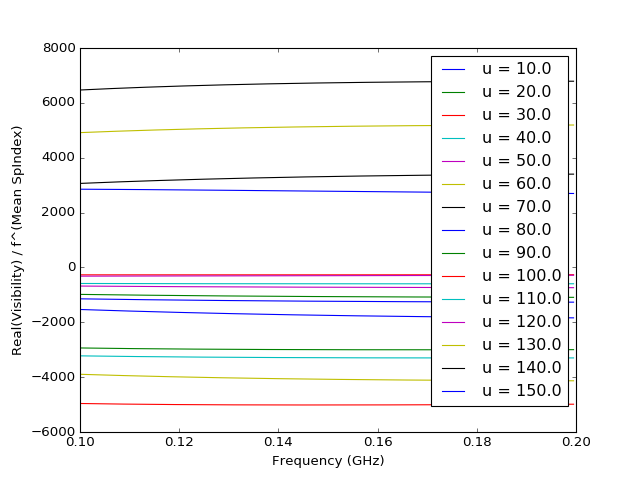

In [13]:
visibilities = visNoBeamGSM
plt.figure(1); plt.clf()
leg = []
allus = np.arange(10,160,.125)
for uindex, u in enumerate(allus):
    if u/ 10.0 == int(u)/10: 
#        plt.semilogy(freqs, np.abs(np.fft.fftshift(np.fft.fft(a.dsp.gen_window(203,'blackman-harris')*visibilities[uindex,:]))),'.')# / np.mean(np.abs(visibilities),axis=0)))#freqs**-.55) / )
        plt.plot(freqs, np.real(visibilities[uindex,:])*freqs**.55)
        leg.append('u = '+str(u))
plt.legend(leg)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Real(Visibility) / f^(Mean SpIndex)')

In [14]:
#plt.figure(2)
#plt.plot(np.mean(np.abs(visibilities),axis=0))

In [15]:
# meanGSMByChan = np.zeros(nchan)

# for chan in tqdm(range(nchan)):
#     GSMmapGalactic = GSM.healpixMap(freqs[chan]*1e3)
#     GSMmap = hp.get_interp_val(GSMmapGalactic,-galCoords.b.radian+np.pi/2, np.asarray(galCoords.l.radian))
#     convertJyToKFactor =  (a.const.c/1e2)**2 / (2 * a.const.k/1e7 * (freqs[chan]*1e9)**2 * 1e26)
#     meanGSMByChan[chan] = np.mean(GSMmap)

In [16]:
# plt.figure(3)
# plt.plot(np.mean(np.abs(visibilities),axis=0)/meanGSMByChan)

order: 0  --- 1.9e-03 to 4.2e-01
order: 1  --- 3.8e-04 to 2.3e-02
order: 2  --- 2.9e-05 to 7.1e-03
order: 3  --- 2.7e-06 to 1.7e-03


<IPython.core.display.Javascript object>


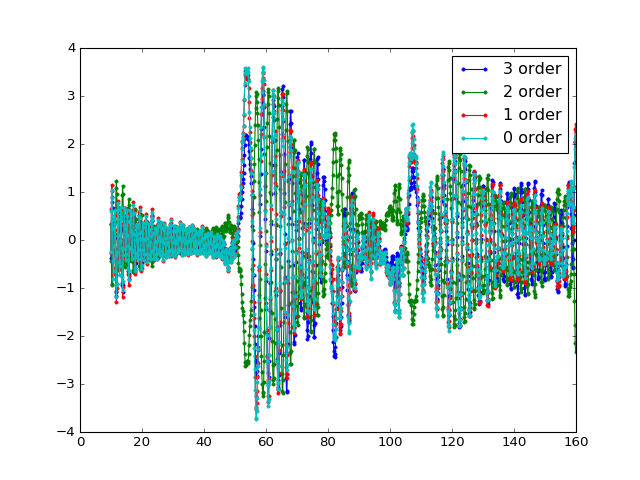

In [17]:
visibilities = visNoBeamGSM
for order in range(4):
    errors = []
    fits = []
    for uindex, u in enumerate(allus):
        visHere =  (visibilities[uindex,:]*freqs**.55)#freqs**np.sum(spectralIndices.dot(fluxes)/np.sum(1.0*fluxes)))
#        visHere = visibilities[uindex,:] / np.mean(np.abs(visibilities),axis=0)
        freqFunc = .15/freqs
#        freqFunc = np.log(-np.log(freqs))
#        freqFunc = np.log(freqs)
        fit = np.polyfit(freqFunc, visHere, order)
        fits.append(fit)
        fitResult = np.polyval(fit, freqFunc)
        error = np.sum(np.abs(visHere - fitResult))/np.sum(np.abs(visHere))
        errors.append(error)
    print  'order:', order, " --- %.1e" % np.min(errors), "to %.1e" % np.max(errors)
#%%
fits = np.asarray(fits)
plt.figure(20); plt.clf()
for o in range(order+1):
    plt.plot(allus, np.real(fits[:,o])/np.mean(np.abs(fits[:,o])),'.-')
plt.legend([str(n) + ' order' for n in range(order,-1,-1)])    
#
#for o in range(order+1): print np.mean(np.abs(fits[:,o]))
#


order: 0  --- 1.1e-01 to 3.4e-01
order: 1  --- 8.4e-03 to 1.4e-01
order: 2  --- 1.6e-03 to 3.3e-02
order: 3  --- 1.1e-03 to 6.2e-03
order: 4  --- 1.0e-03 to 2.5e-03
order: 5  --- 9.9e-04 to 2.4e-03
order: 6  --- 9.8e-04 to 2.4e-03
order: 7  --- 9.8e-04 to 2.4e-03


<IPython.core.display.Javascript object>


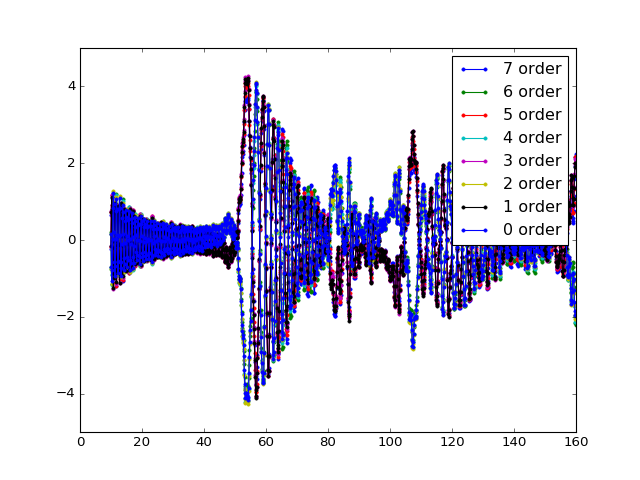

In [18]:
#LEGENDRE FITTING
allus = np.arange(10,160,.125)
visibilities = visNoBeamGSM
for order in range(8):
    errors = []
    fits = []
    for uindex, u in enumerate(allus):
        visHere =  (visibilities[uindex,:]*freqs**-.55)#freqs**np.sum(spectralIndices.dot(fluxes)/np.sum(1.0*fluxes)))
        fit = np.polynomial.legendre.Legendre.fit((freqs-.15)/.05, visHere, order).coef
        fits.append(fit)
        fitResult = np.polynomial.legendre.legval((freqs-.15)/.05,fit)
        error = np.sum(np.abs(visHere - fitResult))/np.sum(np.abs(visHere))
        errors.append(error)
    print  'order:', order, " --- %.1e" % np.min(errors), "to %.1e" % np.max(errors)
#%%
fits = np.asarray(fits)
plt.figure(21); plt.clf()
for o in range(order+1):
    plt.plot(allus, np.real(fits[:,o])/np.mean(np.abs(fits[:,o])),'.-')
plt.legend([str(n) + ' order' for n in range(order,-1,-1)])    
#
#for o in range(order+1): print np.mean(np.abs(fits[:,o]))
#

/Users/jsdillon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/jsdillon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


order: 1  --- 1.4e-04 to 4.5e-01
order: 2  --- 4.7e-06 to 2.5e-02
order: 3  --- 7.6e-11 to 4.5e-08


<IPython.core.display.Javascript object>


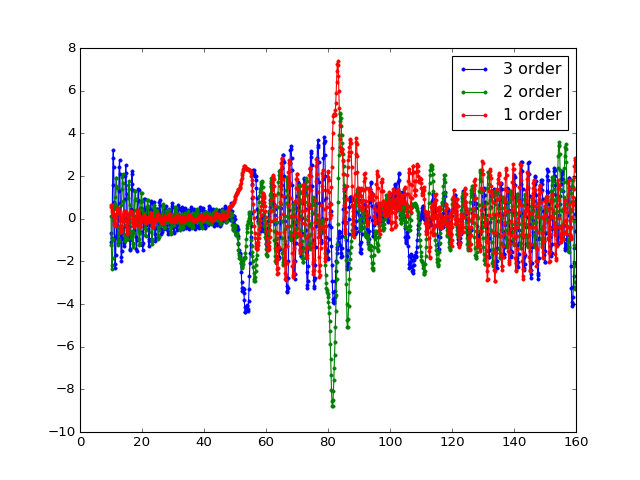

In [19]:
#EIGENVECTOR FITTING
allus = np.arange(10,160,.125)
visibilities = visNoBeamGSM

evals, evecs = SortedEigensystem(np.cov(np.real(visibilities).T))

def evecComboError(coeffs, visReal, visImag, evecs):
    order = len(coeffs)/2
    vis = visReal + 1.0j*visImag
    visModel = evecs[:,0:order].dot(coeffs[0:order]) + 1.0j*evecs[:,0:order].dot(coeffs[order:])
    return np.array(np.abs(vis - visModel),dtype=float)

for order in range(1,4):
    errors = []
    fits = []
    visModels = []
    for uindex, u in enumerate(allus):
        visHere = (visibilities[uindex,:])#freqs**np.sum(spectralIndices.dot(fluxes)/np.sum(1.0*fluxes)))
        guess = np.zeros(2*order,dtype=float)
        guess[0] = np.median(np.real(visHere)/evecs[:,0])
        guess[order] = np.median(np.imag(visHere)/evecs[:,0])
        fit = scipy.optimize.leastsq(evecComboError, guess, args=(np.real(visHere), np.imag(visHere), evecs))[0]
        fits.append(fit)
        visModel = evecs[:,0:order].dot(fit[0:order]) + 1.0j*evecs[:,0:order].dot(fit[order:])
        visModels.append(visModel)
        error = np.sum(np.abs(visHere - visModel))/np.sum(np.abs(visHere))
        errors.append(error)
    print  'order:', order, " --- %.1e" % np.min(errors), "to %.1e" % np.max(errors)
#%%
fits = np.asarray(fits)
plt.figure(22103); plt.clf()
for o in range(1,4):
    plt.plot(allus, np.real(fits[:,o])/np.mean(np.abs(fits[:,o])),'.-')
plt.legend([str(n) + ' order' for n in range(order,-1,-1)])    
#
#for o in range(order+1): print np.mean(np.abs(fits[:,o]))
#

<IPython.core.display.Javascript object>


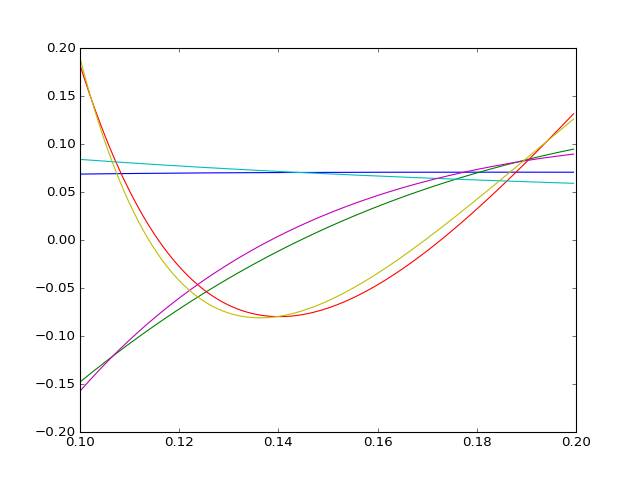

In [15]:
visibilities = visNoBeamGSM
plt.figure(1000)
evals, evecs = SortedEigensystem(np.cov(np.real(visibilities).T))
#evalsRenorm, evecsRenorm = SortedEigensystem(np.cov((np.real(visibilities / np.mean(np.abs(visibilities),axis=0))).T))
renormVis = visibilities*freqs**.55
evalsRenorm, evecsRenorm = SortedEigensystem(np.cov(np.real(renormVis).T))
#plt.semilogy(evals[0:20],'.')
#plt.semilogy(evalsRenorm[0:20]*1e4,'.')
plt.plot(freqs,np.real(evecsRenorm[:,0:3]))
plt.plot(freqs,np.real(evecs[:,0:3]))
np.save('../SkyFreqBasis.npy', np.real(evecsRenorm[:,0:3]))

In [21]:
evecs[:,0].dot(evecs[:,1])

(7.9330559778356694e-17+0j)

<IPython.core.display.Javascript object>


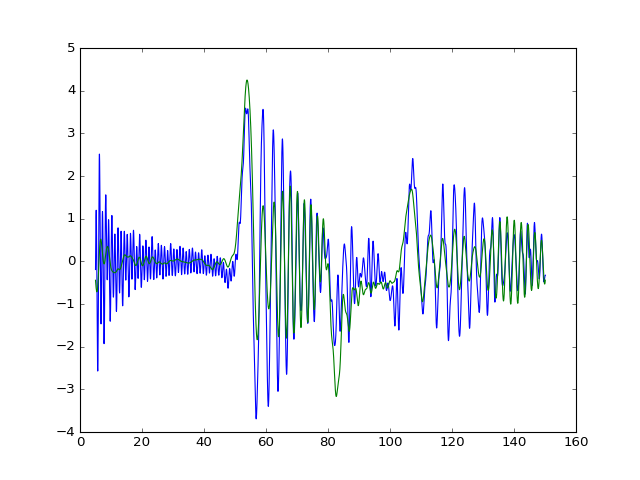

In [22]:
plt.figure(100)
plt.plot(fullus, np.real(alluVisNoBeamGSM)/np.mean(np.abs(alluVisNoBeamGSM),axis=0))
plt.plot(fullus, np.real(alluVisPAPERBeamGSM/np.mean(np.abs(alluVisPAPERBeamGSM),axis=0)))

<IPython.core.display.Javascript object>


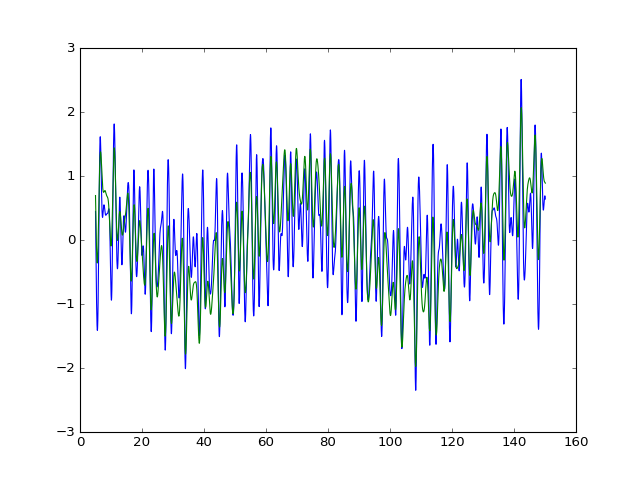

In [23]:
plt.figure(101)
plt.plot(fullus, np.real(alluVisNoBeamPS)/np.mean(np.abs(alluVisNoBeamPS),axis=0))
plt.plot(fullus, np.real(alluVisPAPERBeamPS/np.mean(np.abs(alluVisPAPERBeamPS),axis=0)))

In [9]:
deltau = 15 * (1e8) / nchan / const.c
uSampling = 10 * deltau
fullus = np.arange(15*(1e8) / const.c, 15*15*(2e8) / const.c + deltau, deltau)
uSamples = np.arange(15*(1e8) / const.c - 10*uSampling, 15*15*(2e8) / const.c + 10*uSampling, uSampling)
chans = [100]
visFull = computeVisibilityGrid(fullus, chans, useGSM=True, usePAPERBeam=False, useAiryBeam=False)[:,chans[0]]
visSamp = computeVisibilityGrid(uSamples, chans, useGSM=True, usePAPERBeam=False, useAiryBeam=False)[:,chans[0]]

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


<IPython.core.display.Javascript object>


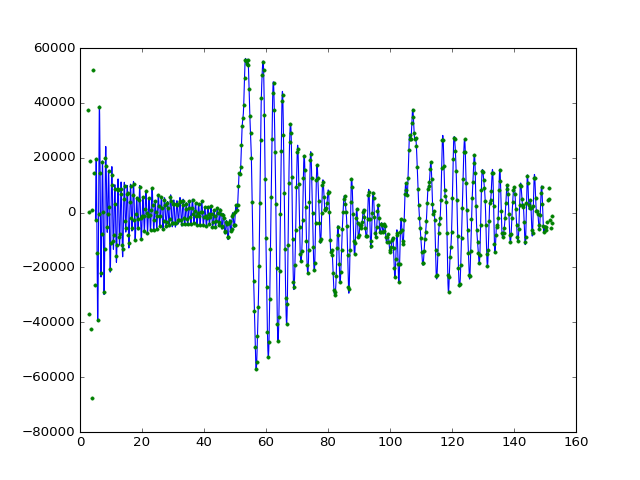

In [10]:
plt.figure(545)

plt.plot(fullus, np.real(visFull),'-')
plt.plot(uSamples, np.real(visSamp),'.')

<IPython.core.display.Javascript object>


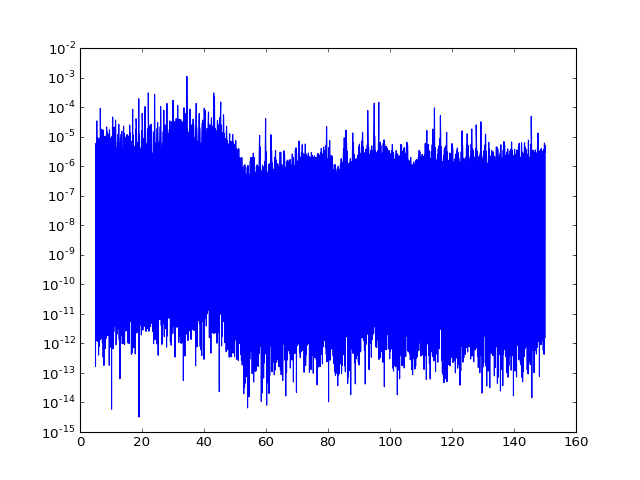

In [11]:
f = interp1d(uSamples, np.real(visSamp), kind=10)
interpolated = f(fullus)
plt.figure(542)
plt.semilogy(fullus,np.abs(np.real(visFull)-interpolated)/np.abs(visFull))

In [12]:
# visFullPS = computeVisibilityGrid(fullus, chans, useGSM=False, usePAPERBeam=False, useAiryBeam=False)[:,chans[0]]
# plt.figure(20202020)
# plt.plot(fullus,visFullPS)

<IPython.core.display.Javascript object>


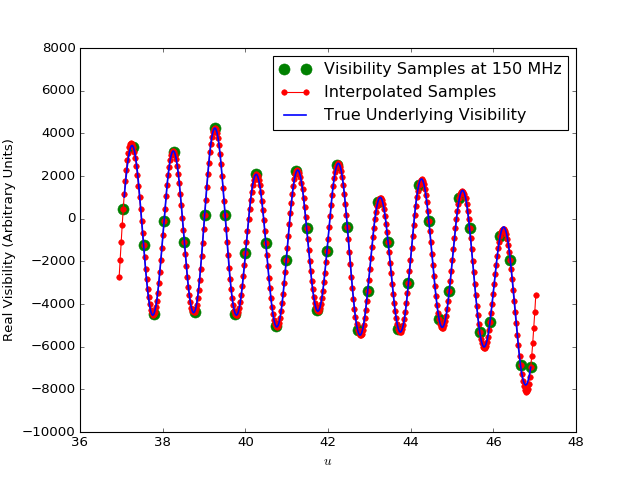

/Users/jsdillon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5889 but corresponding boolean dimension is 5888


In [45]:
sampling = 10 * 15 * (1e8) / nchan / const.c
pad = 4.5
fullus = np.arange(15*(1e8) / const.c, 15*15*(2e8) / const.c, deltau)

toInterpolate = visSamp[140:181]
uBins = uSamples[140:181]
allu = np.arange(uBins[0]-int(np.floor(pad))*sampling/(2*pad+1), uBins[-1]+int(np.ceil(pad))*sampling/(2*pad+1)+1e-10, sampling/(2*pad+1))

def FourierInterpolate(toInterpolate, pad, nuSamples):
    toPad = np.fft.fftshift(np.fft.fft(toInterpolate))
    padded = np.concatenate((np.zeros(int(np.ceil(nuSamples*pad+.5))), toPad, np.zeros(int(np.floor(nuSamples*pad-.5)))))
    interpolated = np.roll((2*pad+1)*np.fft.ifft(np.fft.fftshift(padded)),int(np.floor(pad)))
    return interpolated

interpolated = FourierInterpolate(toInterpolate, pad, len(uBins))
#print len(toInterpolate), len(uBins)

plt.figure(1202122232)

plt.plot(uBins,np.real(toInterpolate),'g.',ms=20)
plt.plot(allu,np.real(interpolated),'r.-',ms=10)
plt.plot(fullus[(fullus>=uBins[0]) * (fullus<=uBins[-1])], np.real(visFull[(fullus>=uBins[0]) * (fullus<=uBins[-1])]),'b-',lw=1.5)
#print len(allu), len(interpolated)
plt.legend(['Visibility Samples at 150 MHz','Interpolated Samples','True Underlying Visibility'])
plt.ylabel('Real Visibility (Arbitrary Units)')
plt.xlabel('$u$')
plt.ylim([-10000,8000])
plt.savefig('/Users/jsdillon/Documents/Presentations and Talks/Conferences/2017 URSI/FourierInterpolation.pdf',bbox_inches='tight')

41
41.0


<IPython.core.display.Javascript object>


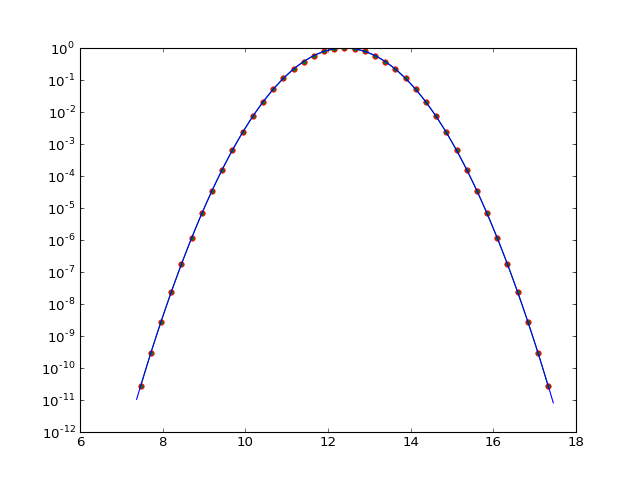

In [28]:
def FourierInterpolate(toInterpolate, pad, nuSamples):
    toPad = np.fft.fftshift(np.fft.fft(toInterpolate))
    padded = np.concatenate((np.zeros(int(np.ceil(nuSamples*pad+.5))), toPad, np.zeros(int(np.floor(nuSamples*pad-.5)))))
    interpolated = np.roll((2*pad+1)*np.fft.ifft(np.fft.fftshift(padded)),int(np.floor(pad)))
    return interpolated

FIMatrix = np.zeros((len(toInterpolate), int(len(toInterpolate)*(2*pad+1))), dtype=complex)
for row in range(len(toInterpolate)):
    rowIn = np.zeros(len(toInterpolate))
    rowIn[row] = 1.0
    FIMatrix[row,:] = FourierInterpolate(rowIn, pad, len(uBins)) /(2*pad+1)

testBeam = np.abs(np.exp(-(allu-allu[len(allu)/2-1])**2))# * (2+np.sin(allu*5)))/2

test = np.roll(testBeam, -int(np.floor(pad))) / (2*pad+1)
test = np.fft.ifftshift(np.fft.fft(test))
test = test[int(np.ceil(len(uBins)*pad+.5)): int(np.ceil(len(uBins)*pad+.5))+len(uBins)]
test = np.fft.ifft(np.fft.ifftshift(test)) #* len(test) / len(testBeam) * -1

print len(uBins)
print len(testBeam)/(2*pad+1)
plt.figure(9929)
#print int(np.ceil(len(uBins)*pad+.5))
#plt.plot(allu,np.real(FIMatrix[15,:]))

plt.semilogy(uBins, FIMatrix.dot(testBeam),'r.',ms=10)
plt.semilogy(uBins,np.real(test),'g.-')
plt.semilogy(allu,testBeam,'b')